### How to visualise the batches and compare it with model predictions

In [24]:
import os
import hydra
from hydra.core.global_hydra import GlobalHydra
import pickle
GlobalHydra.instance().clear()

from omegaconf import DictConfig, OmegaConf
from torch.utils.data import DataLoader
from src.bfm.src.dataloder import LargeClimateDataset, custom_collate

In [2]:
hydra.initialize(config_path="", version_base=None)
cfg = hydra.compose(config_name="viz_config")
print(OmegaConf.to_yaml(cfg))

cfg = hydra.compose(config_name="viz_config.yaml", overrides=["data.scaling.enabled=False",
    "data.scaling.stats_path=/home/thanasis.trantas/git_projects/bfm-model/batch_statistics/statistics.json",])


dataset = LargeClimateDataset(data_dir="/home/thanasis.trantas/git_projects/bfm-model/data_small/rollout", scaling_settings=cfg.data.scaling ,num_species=cfg.data.species_number)

viz_dataloader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=15,
    collate_fn=custom_collate,
    drop_last=True,
    shuffle=False,
)

len(viz_dataloader)

model:
  T: 2
  V_surf: 2
  V_atmos: 2
  C: 3
  V_spec: 1
  V_land: 2
  V_agri: 4
  V_forest: 1
  H: 152
  W: 320
  num_latent_tokens: 8
  backbone: swin
  patch_size: 4
  embed_dim: 512
  num_heads: 16
  head_dim: 64
  depth: 2
data:
  atmos_levels:
  - 50
  - 500
  - 1000
  species_number: 22
  data_path: /home/thanasis.trantas/git_projects/bfm-model/data_small
  test_data_path: /home/thanasis.trantas/git_projects/bfm-model/data_small
  scaling:
    enabled: true
    stats_path: batch_statistics/statistics.json
    mode: normalize
training:
  batch_size: 1
  workers: 15
  epochs: 2
  accelerator: gpu
  precision: bf16-mixed
  precision_in: medium
  devices:
  - 0
  strategy: fsdp
  num_nodes: 1
  gradient_clip: 1.0
  log_steps: 1
  lr: 5.0e-05
  wd: 5.0e-07
  checkpoint_path: false
  eval_every: 2
general:
  do_eval: true
mlflow:
  port: 8082
evaluation:
  checkpoint_path: /home/thanasis.trantas/git_projects/bfm-model/outputs/2025-02-24/12-32-16/checkpoints/epoch=1-step=8.ckpt
  batc

1

In [12]:
sample = next(iter(viz_dataloader))
sample
# Load the rollout dictionary for visualisation
# with open("rollouts.pkl", 'rb') as f:
#     sample_dict = pickle.load(f)
sample


Batch(batch_metadata=Metadata(latitudes=tensor([72.0000, 71.7500, 71.5000, 71.2500, 71.0000, 70.7500, 70.5000, 70.2500,
        70.0000, 69.7500, 69.5000, 69.2500, 69.0000, 68.7500, 68.5000, 68.2500,
        68.0000, 67.7500, 67.5000, 67.2500, 67.0000, 66.7500, 66.5000, 66.2500,
        66.0000, 65.7500, 65.5000, 65.2500, 65.0000, 64.7500, 64.5000, 64.2500,
        64.0000, 63.7500, 63.5000, 63.2500, 63.0000, 62.7500, 62.5000, 62.2500,
        62.0000, 61.7500, 61.5000, 61.2500, 61.0000, 60.7500, 60.5000, 60.2500,
        60.0000, 59.7500, 59.5000, 59.2500, 59.0000, 58.7500, 58.5000, 58.2500,
        58.0000, 57.7500, 57.5000, 57.2500, 57.0000, 56.7500, 56.5000, 56.2500,
        56.0000, 55.7500, 55.5000, 55.2500, 55.0000, 54.7500, 54.5000, 54.2500,
        54.0000, 53.7500, 53.5000, 53.2500, 53.0000, 52.7500, 52.5000, 52.2500,
        52.0000, 51.7500, 51.5000, 51.2500, 51.0000, 50.7500, 50.5000, 50.2500,
        50.0000, 49.7500, 49.5000, 49.2500, 49.0000, 48.7500, 48.5000, 48.2500,


In [23]:
groups = [
    "surface_variables",
    "single_variables",
    "atmospheric_variables",
    "species_extinction_variables",
    "land_variables",
    "agriculture_variables",
    "forest_variables",
    "species_variables",
]

# for i, batch_dict in enumerate(sample_dict["batches"]):
for group_name in groups:

    # pred_dict = sample[group_name]
    true_dict = getattr(sample, group_name)
    for var_name, pred_tensor in true_dict.items():
        sample_tensor = true_dict[var_name]
        print(group_name)
        print(var_name)
        print(sample_tensor.shape)

# Now, also access the metadata:
if hasattr(sample, "batch_metadata"):
    metadata = sample.batch_metadata
    print("Batch Metadata:")
    # If metadata is a namedtuple (has _fields), iterate over its fields.
    if hasattr(metadata, "_fields"):
        for field in metadata._fields:
            value = getattr(metadata, field)
            if isinstance(value, torch.Tensor):
                print(f"  {field}: shape = {value.shape}")
            else:
                print(f"  {field}: {value}")
    else:
        print(metadata)

surface_variables
t2m
torch.Size([1, 2, 152, 320])
surface_variables
msl
torch.Size([1, 2, 152, 320])
single_variables
lsm
torch.Size([1, 2, 152, 320])
atmospheric_variables
z
torch.Size([1, 2, 3, 152, 320])
atmospheric_variables
t
torch.Size([1, 2, 3, 152, 320])
species_extinction_variables
ExtinctionValue
torch.Size([1, 2, 152, 320])
land_variables
NDVI
torch.Size([1, 2, 152, 320])
land_variables
Land
torch.Size([1, 2, 152, 320])
agriculture_variables
AgricultureLand
torch.Size([1, 2, 152, 320])
agriculture_variables
AgricultureIrrLand
torch.Size([1, 2, 152, 320])
agriculture_variables
ArableLand
torch.Size([1, 2, 152, 320])
agriculture_variables
Cropland
torch.Size([1, 2, 152, 320])
forest_variables
Forest
torch.Size([1, 2, 152, 320])
species_variables
Distribution
torch.Size([1, 2, 22, 152, 320])
Batch Metadata:
  latitudes: shape = torch.Size([152])
  longitudes: shape = torch.Size([320])
  timestamp: ['2020-05-29T18:00:00', '2020-05-30T00:00:00']
  lead_time: 6.0
  pressure_level

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import torch

def plot_europe_timesteps_and_difference(var_name, tensor, channel_idx=None):
    """
    Given a tensor with shape either:
      - [batch, 2, lat, lon]  OR
      - [batch, 2, channel, lat, lon],
    this function extracts data for timestep 1 and timestep 2 and computes the difference.
    
    Instead of using coordinates extracted from the tensor, we use fixed coordinate arrays:
      - Latitude: 152 values starting at 72.0000 and decreasing by 0.25 down to 34.2500.
      - Longitude: 320 values linearly spaced from -30.0000 to 40.0000.
      
    Three subplots are then created over Europe using Cartopy.
    
    Parameters:
      var_name (str): Name of the variable (used in plot titles).
      tensor (torch.Tensor): Input tensor.
      channel_idx (int, optional): For 5D tensors, index of the channel to plot.
    """
    tensor_np = tensor.cpu().numpy()
    
    # Extract data slices from the tensor
    if tensor_np.ndim == 4:
        # Shape: [batch, 2, lat, lon]
        t1 = tensor_np[0, 0, :, :]
        t2 = tensor_np[0, 1, :, :]
    elif tensor_np.ndim == 5:
        # Shape: [batch, 2, channel, lat, lon]
        if channel_idx is None:
            channel_idx = 0
        t1 = tensor_np[0, 0, channel_idx, :, :]
        t2 = tensor_np[0, 1, channel_idx, :, :]
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor_np.shape}")
    
    # Compute the difference between timestep 2 and timestep 1
    diff = t2 - t1
    
    # Create fixed coordinate arrays:
    # Latitude: starting at 72.0000, decrement by 0.25 for 152 points.
    lat_fixed = np.linspace(72, 34.25, 152)
    # For plotting, it's common to have latitudes in ascending order.
    lat_fixed = np.sort(lat_fixed)  # now from 34.25 to 72.00
    
    # Longitude: 320 values linearly spaced from -30.0000 to 40.0000.
    lon_fixed = np.linspace(-30, 40, 320)
    
    # Create a coordinate meshgrid with indexing='xy'
    Lon, Lat = np.meshgrid(lon_fixed, lat_fixed, indexing='xy')
    print("Using fixed coordinate grid:")
    print("Latitude range:", lat_fixed[0], "to", lat_fixed[-1])
    print("Longitude range:", lon_fixed[0], "to", lon_fixed[-1])
    print("Meshgrid shapes: Lon:", Lon.shape, "Lat:", Lat.shape)
    
    # Define the Europe bounding box (for setting plot extent)
    europe_extent = [-30, 40, 34.25, 72]  # [lon_min, lon_max, lat_min, lat_max]
    
    # Create a figure with 3 subplots using Cartopy PlateCarree projection.
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot Timestep 1
    ax = axes[0]
    ax.set_extent(europe_extent, crs=ccrs.PlateCarree())
    try:
        ax.coastlines(resolution='50m')
    except Exception as e:
        print("Error drawing coastlines on Timestep 1:", e)
    cf1 = ax.contourf(Lon, Lat, t1, levels=60, cmap='viridis', transform=ccrs.PlateCarree())
    ax.set_title(f"{var_name} - Timestep 1")
    fig.colorbar(cf1, ax=ax, orientation='vertical', label="Value")
    
    # Plot Timestep 2
    ax = axes[1]
    ax.set_extent(europe_extent, crs=ccrs.PlateCarree())
    try:
        ax.coastlines(resolution='50m')
    except Exception as e:
        print("Error drawing coastlines on Timestep 2:", e)
    cf2 = ax.contourf(Lon, Lat, t2, levels=60, cmap='viridis', transform=ccrs.PlateCarree())
    ax.set_title(f"{var_name} - Timestep 2")
    fig.colorbar(cf2, ax=ax, orientation='vertical', label="Value")
    
    # Plot Difference (Timestep 2 - Timestep 1)
    ax = axes[2]
    ax.set_extent(europe_extent, crs=ccrs.PlateCarree())
    try:
        ax.coastlines(resolution='50m')
    except Exception as e:
        print("Error drawing coastlines on Difference plot:", e)
    cf_diff = ax.contourf(Lon, Lat, diff, levels=60, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.set_title(f"{var_name} - Difference (T2 - T1)")
    fig.colorbar(cf_diff, ax=ax, orientation='vertical', label="Difference")
    
    plt.tight_layout()
    plt.show()


Plotting surface_variables:t2m with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


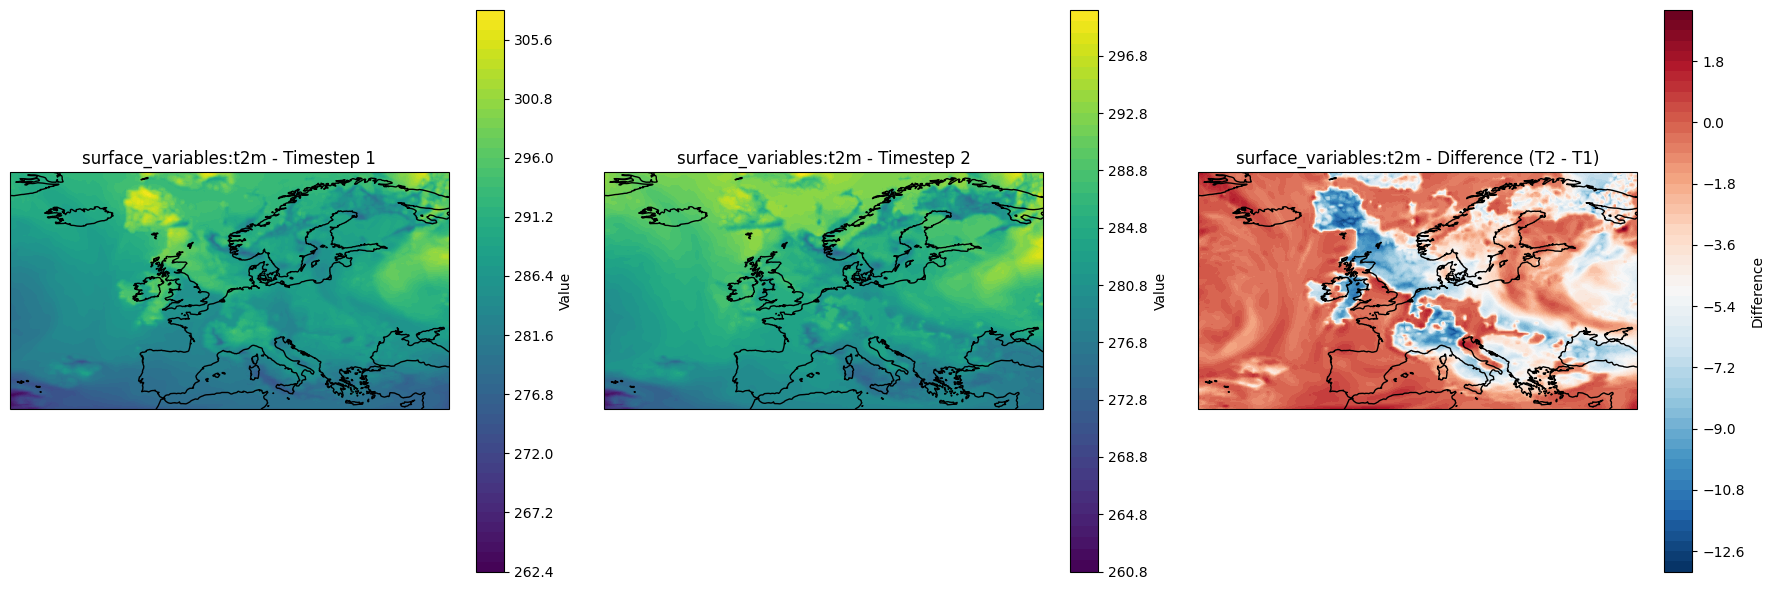

Plotting surface_variables:msl with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


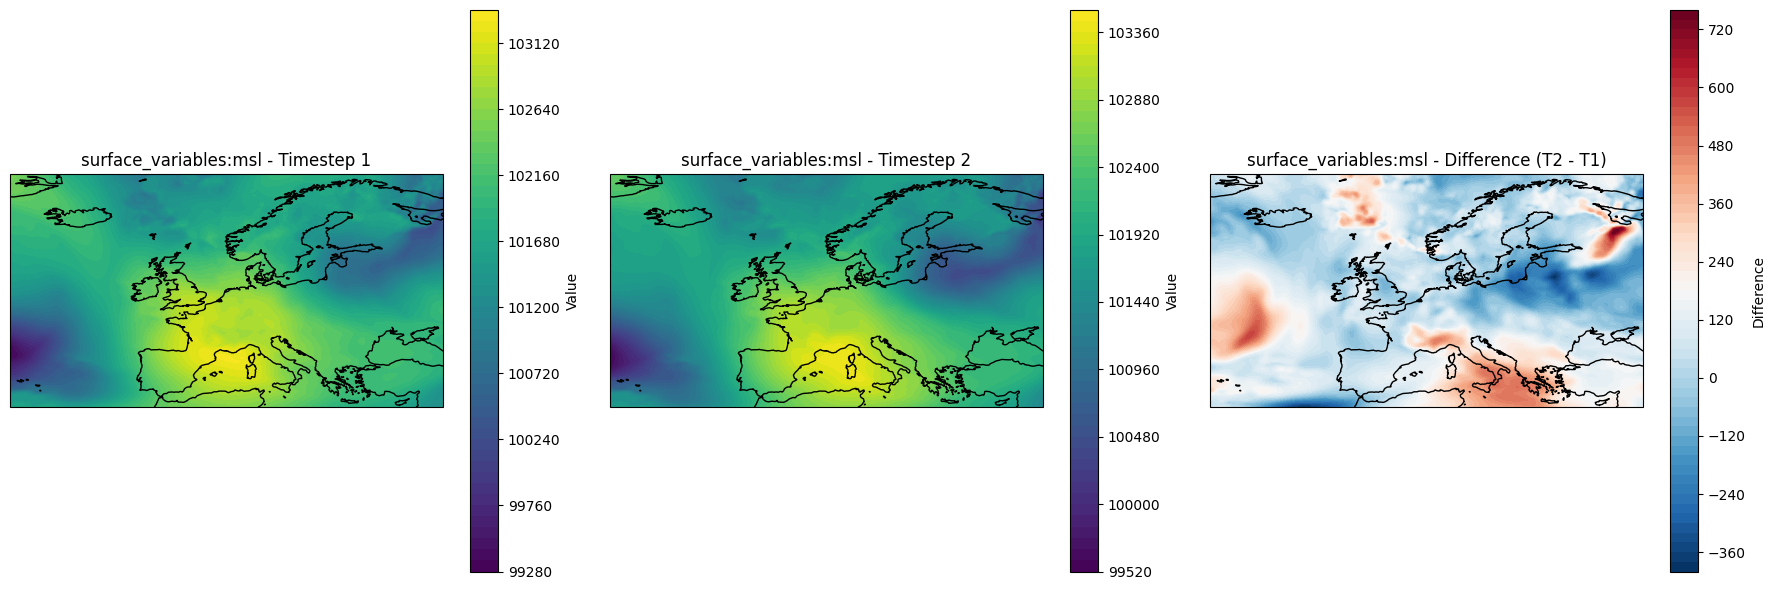

Plotting single_variables:lsm with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


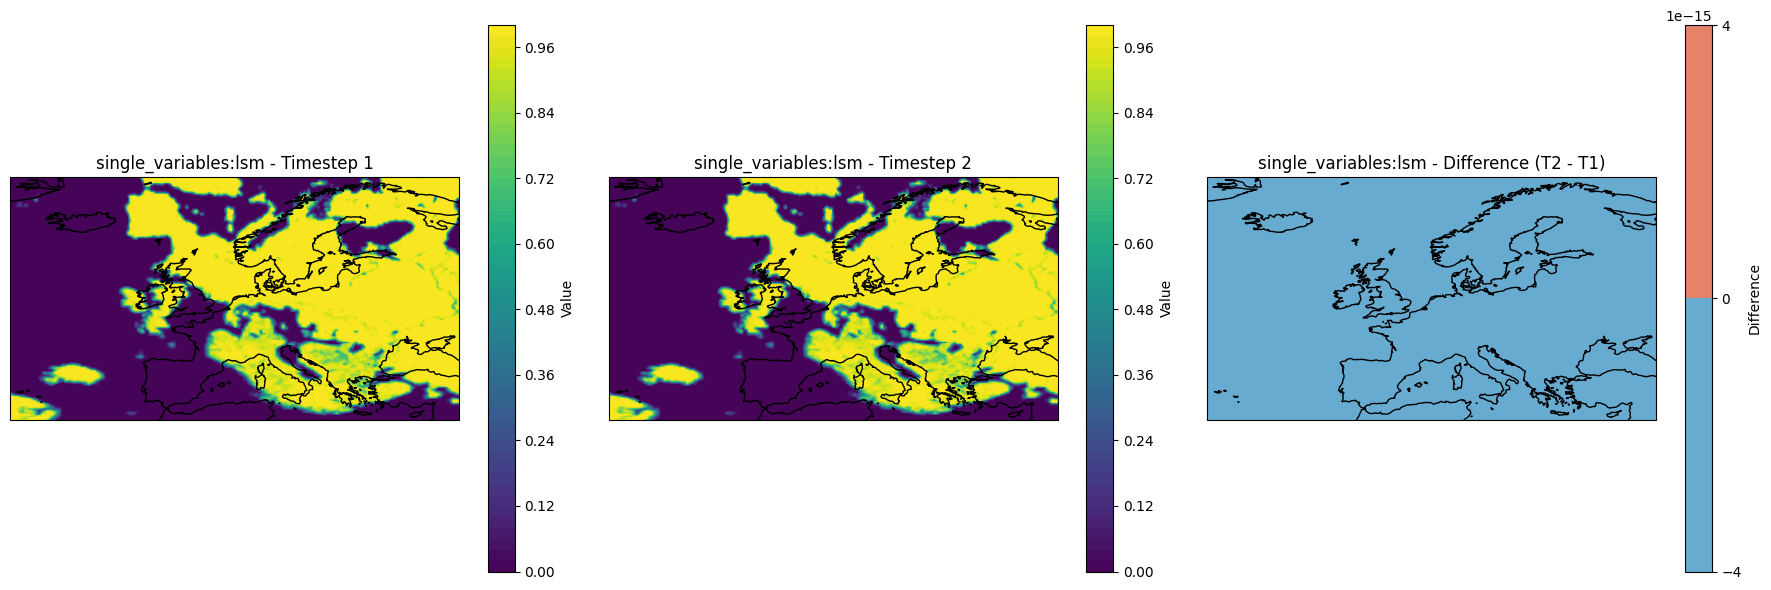

Plotting atmospheric_variables:z with shape torch.Size([1, 2, 3, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


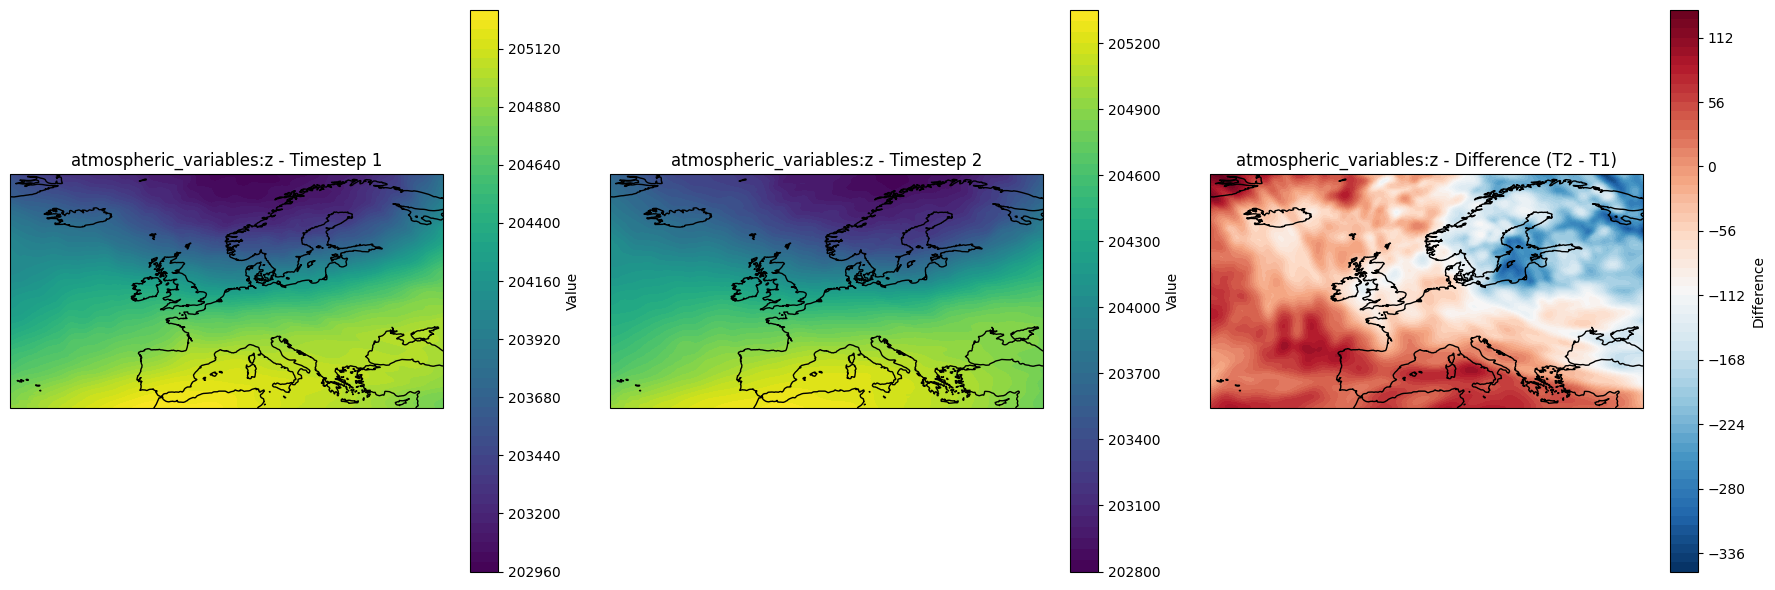

Plotting atmospheric_variables:t with shape torch.Size([1, 2, 3, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


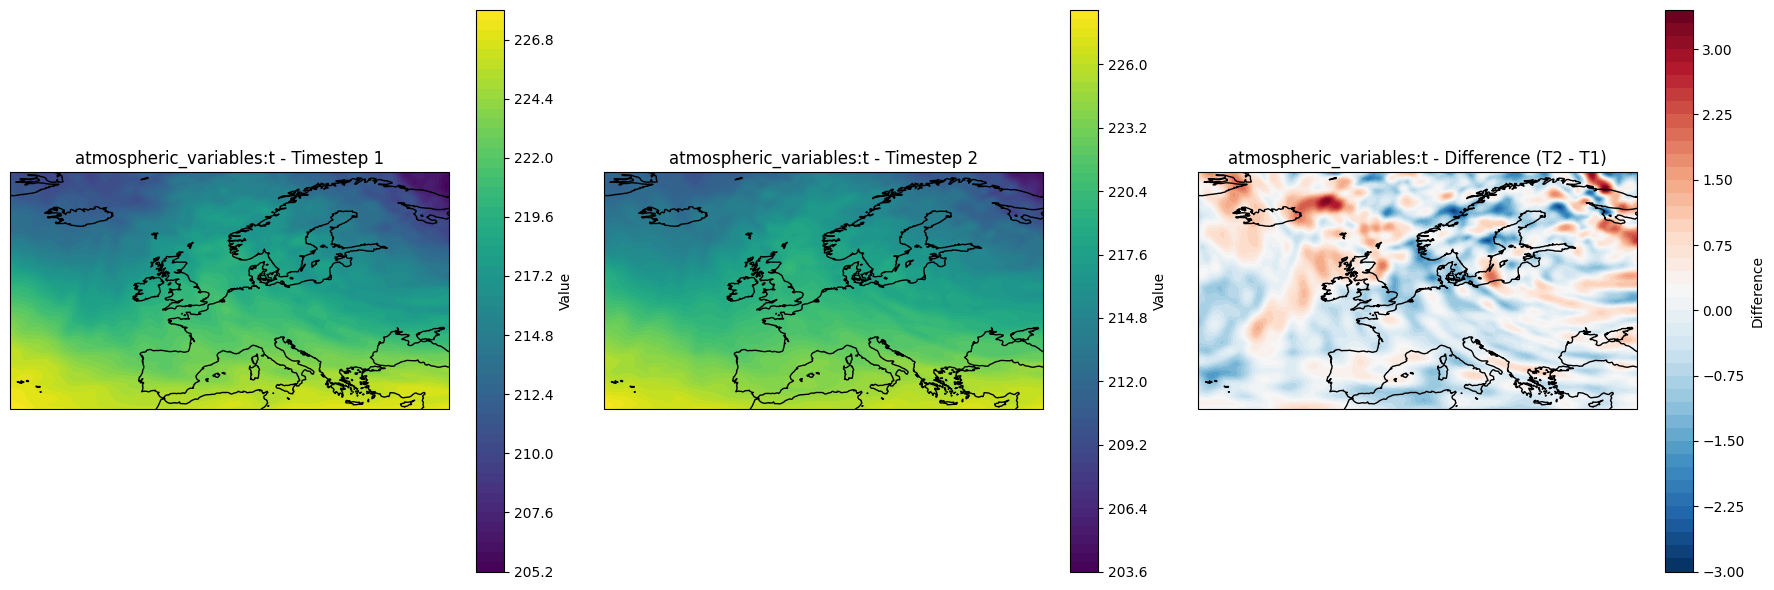

Plotting species_extinction_variables:ExtinctionValue with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


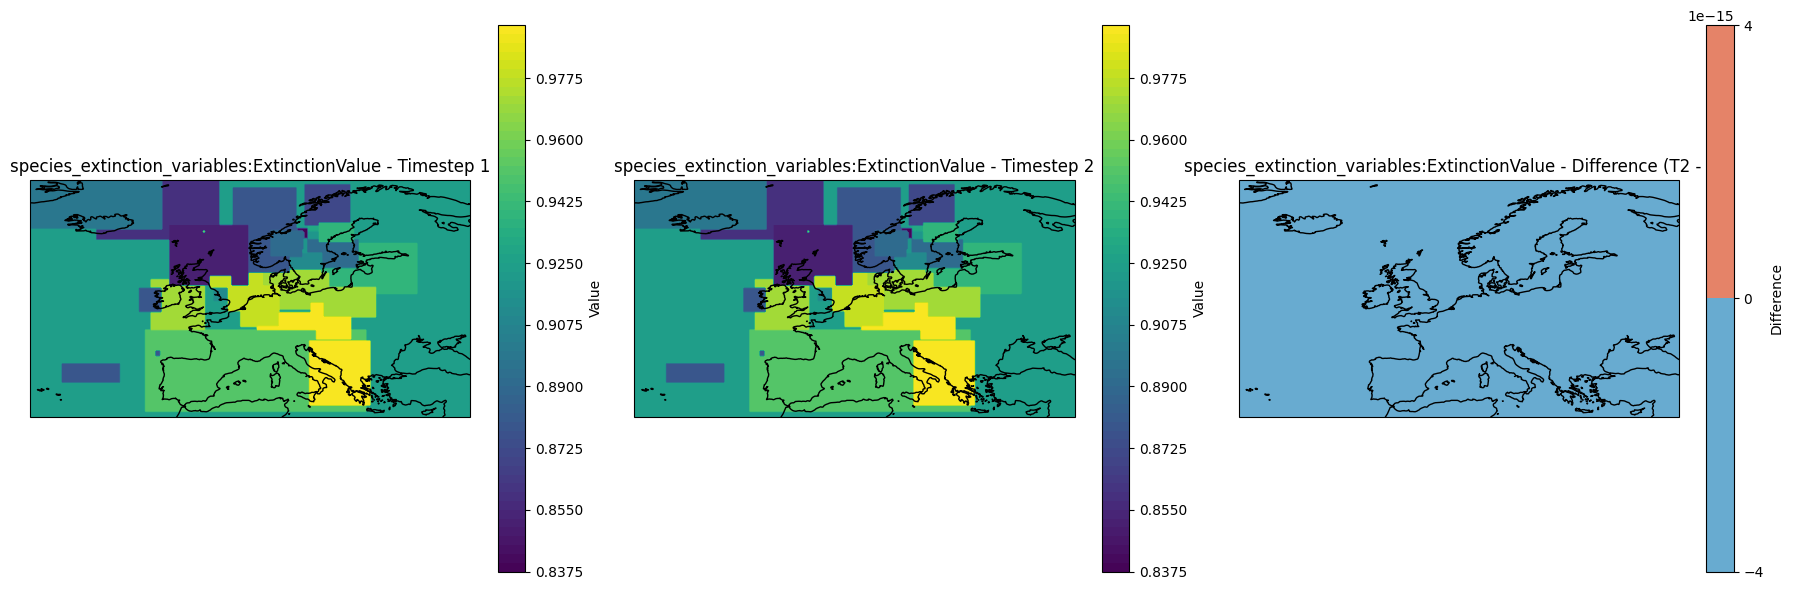

Plotting land_variables:NDVI with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


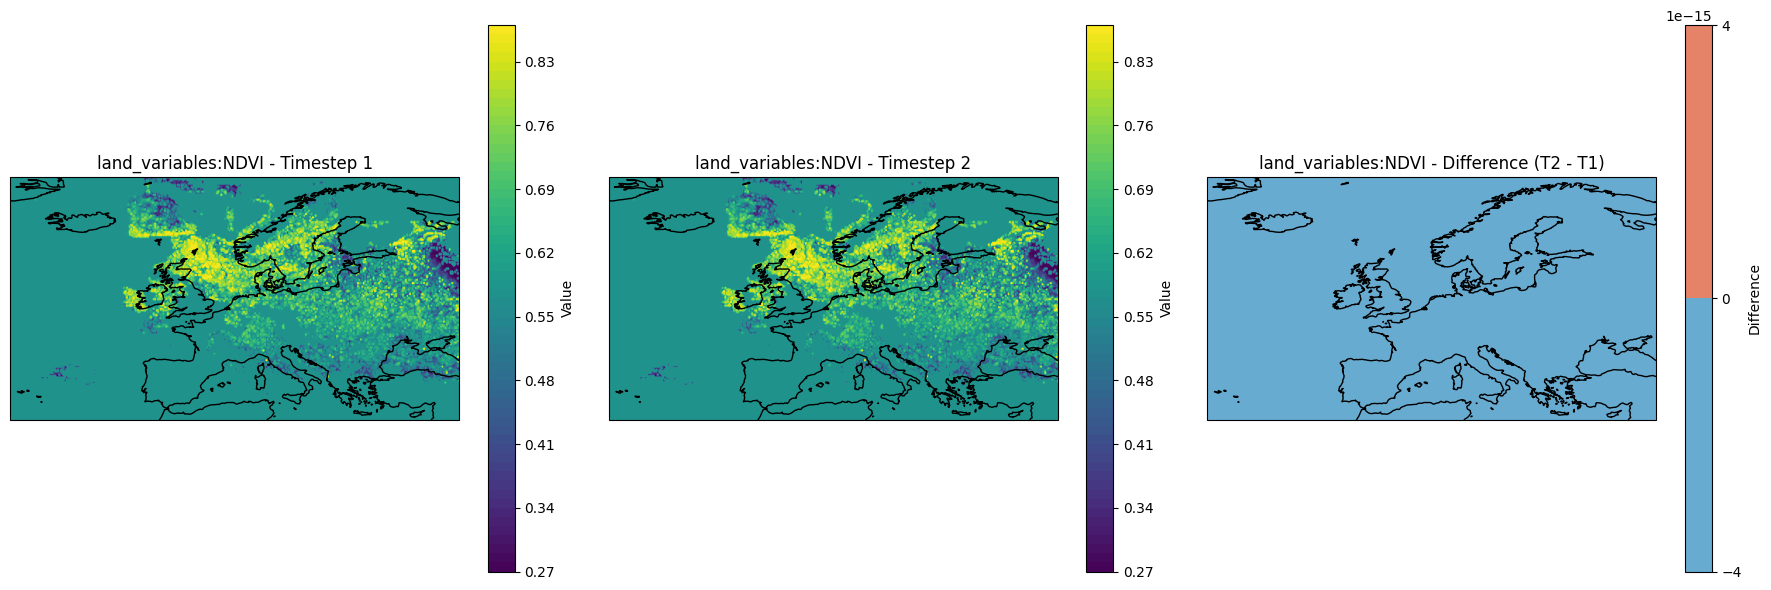

Plotting land_variables:Land with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


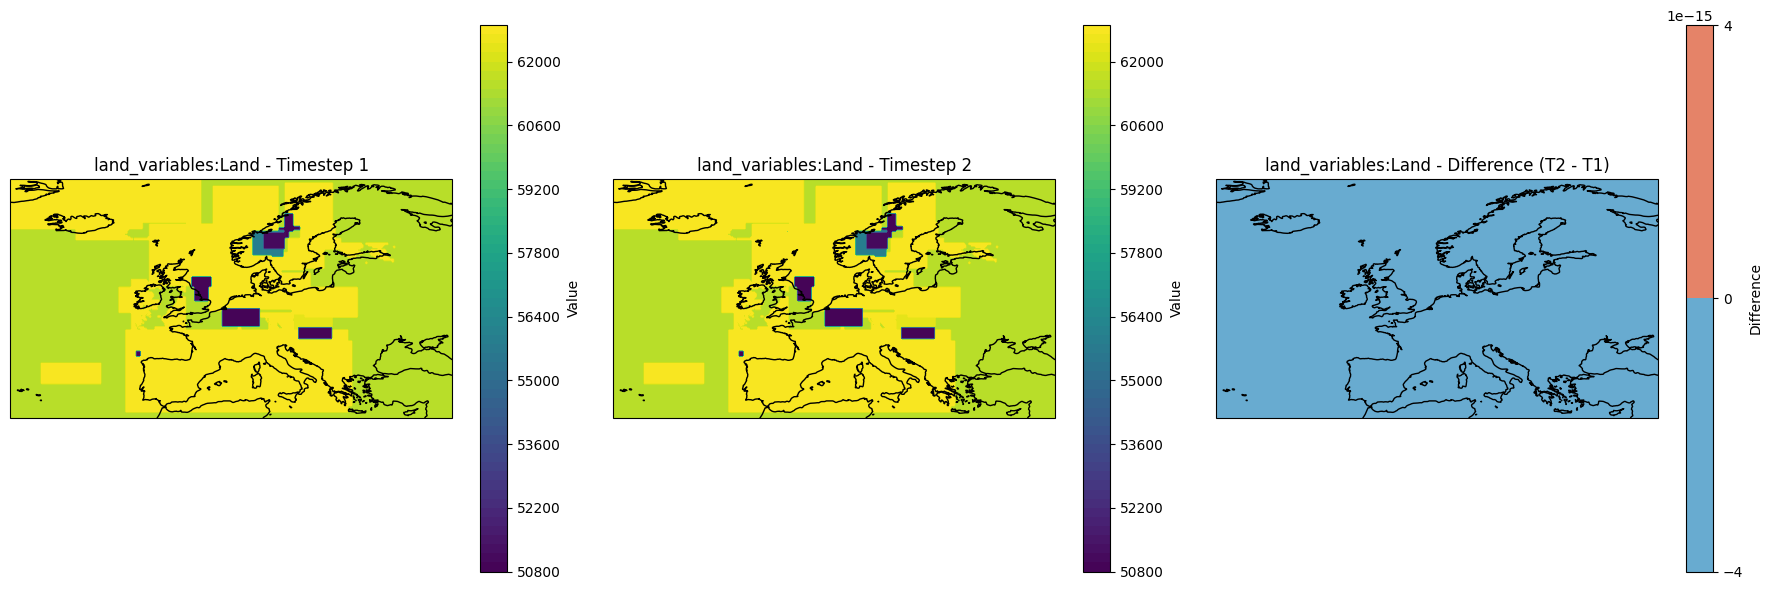

Plotting agriculture_variables:AgricultureLand with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


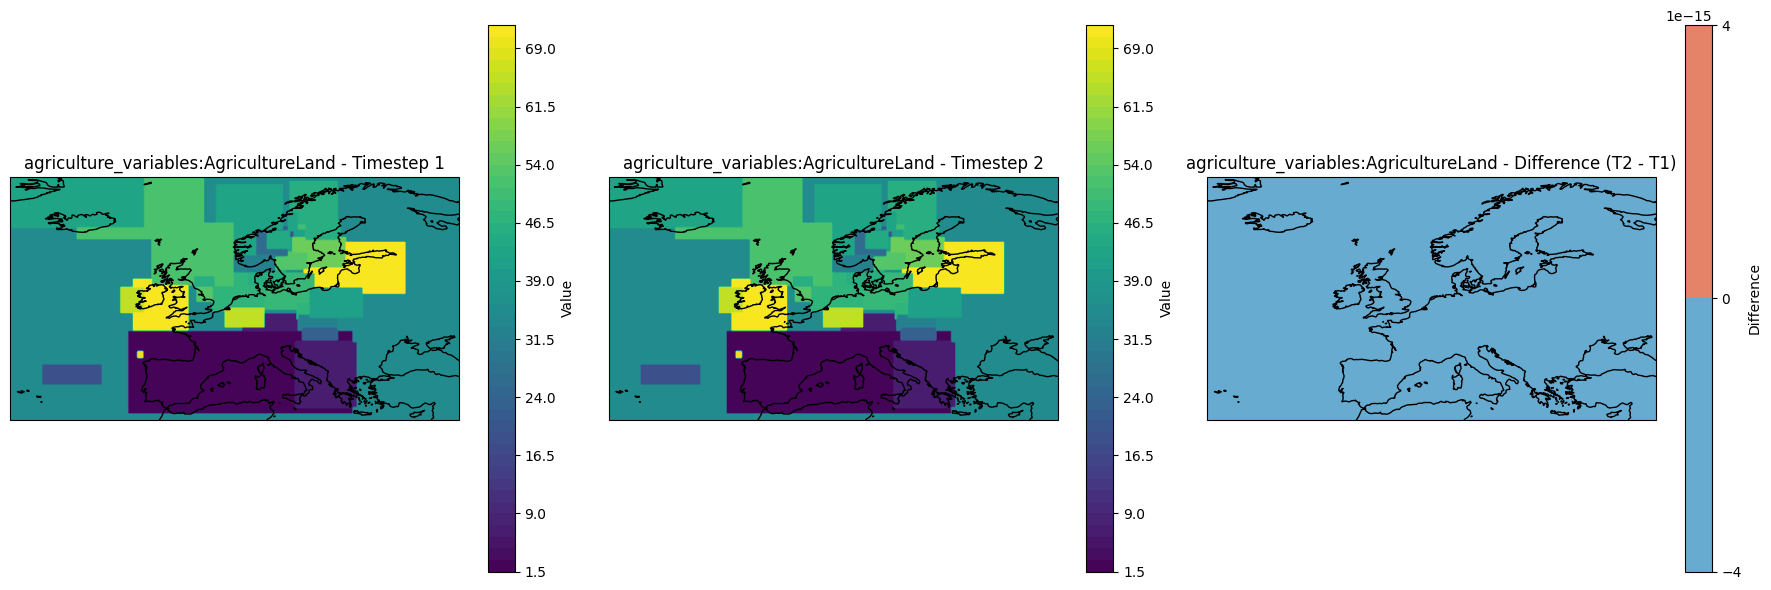

Plotting agriculture_variables:AgricultureIrrLand with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


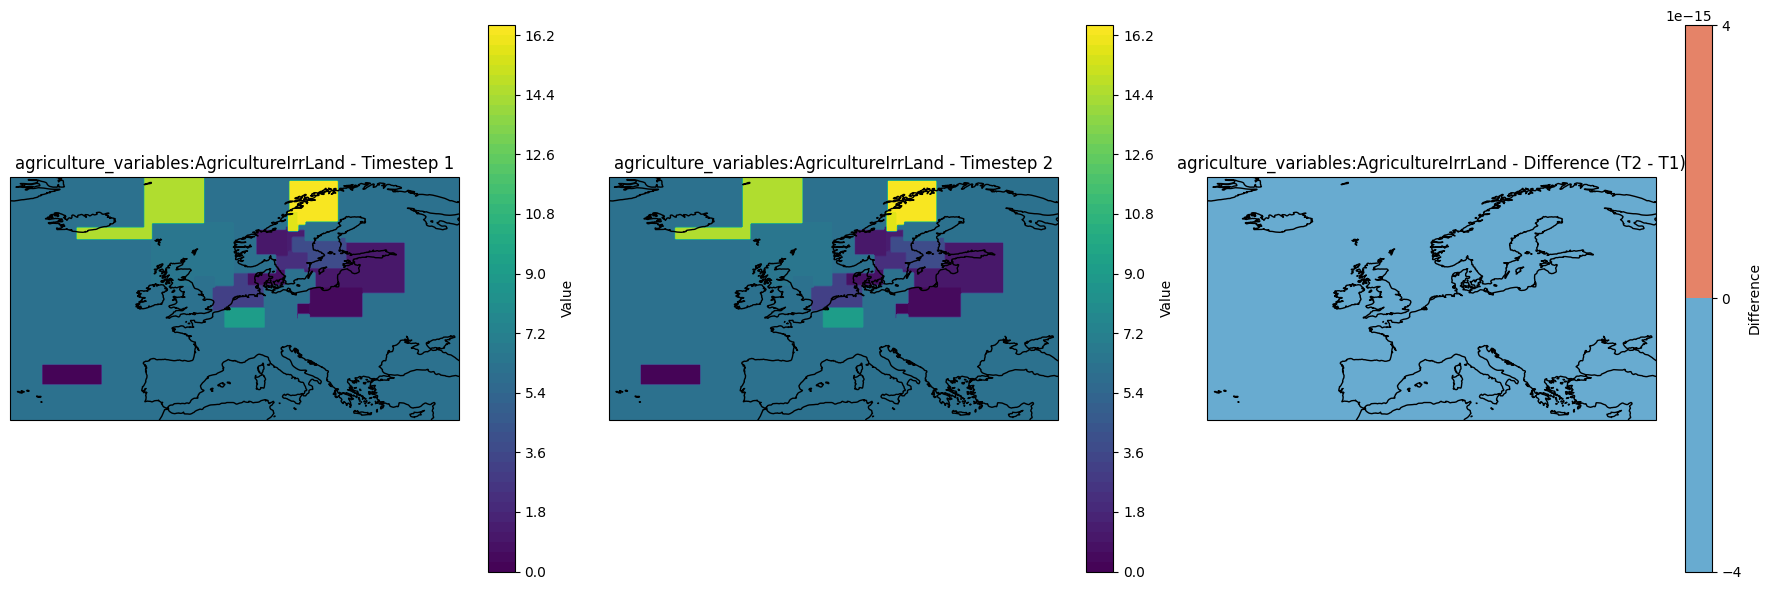

Plotting agriculture_variables:ArableLand with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


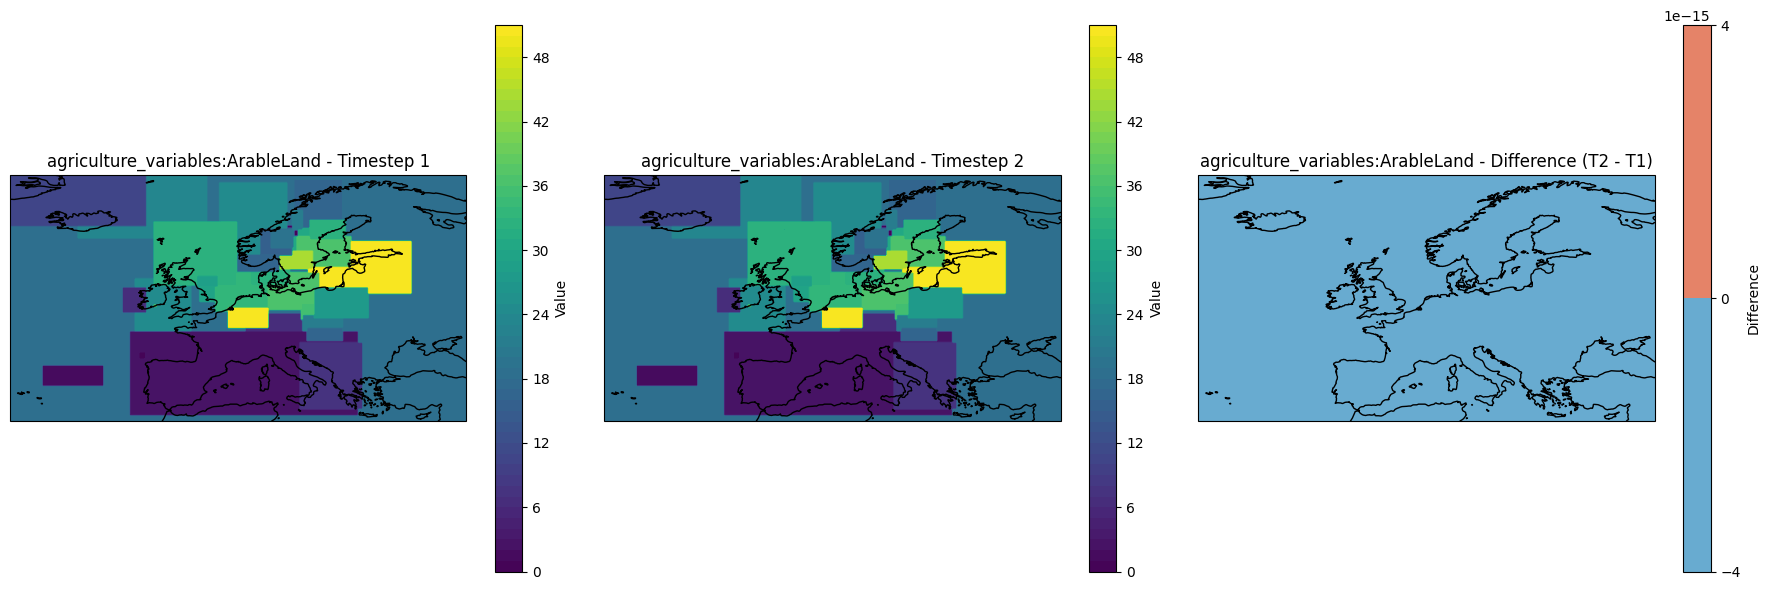

Plotting agriculture_variables:Cropland with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


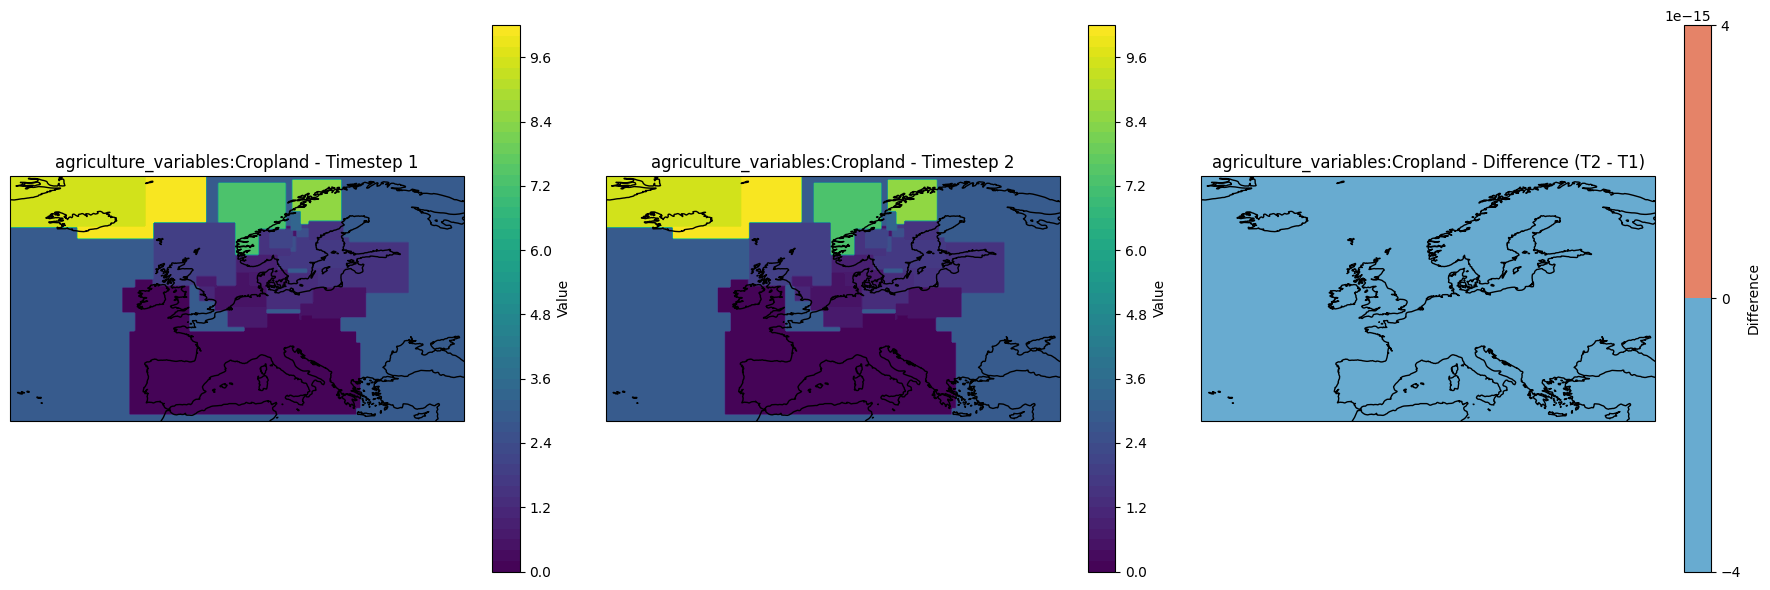

Plotting forest_variables:Forest with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


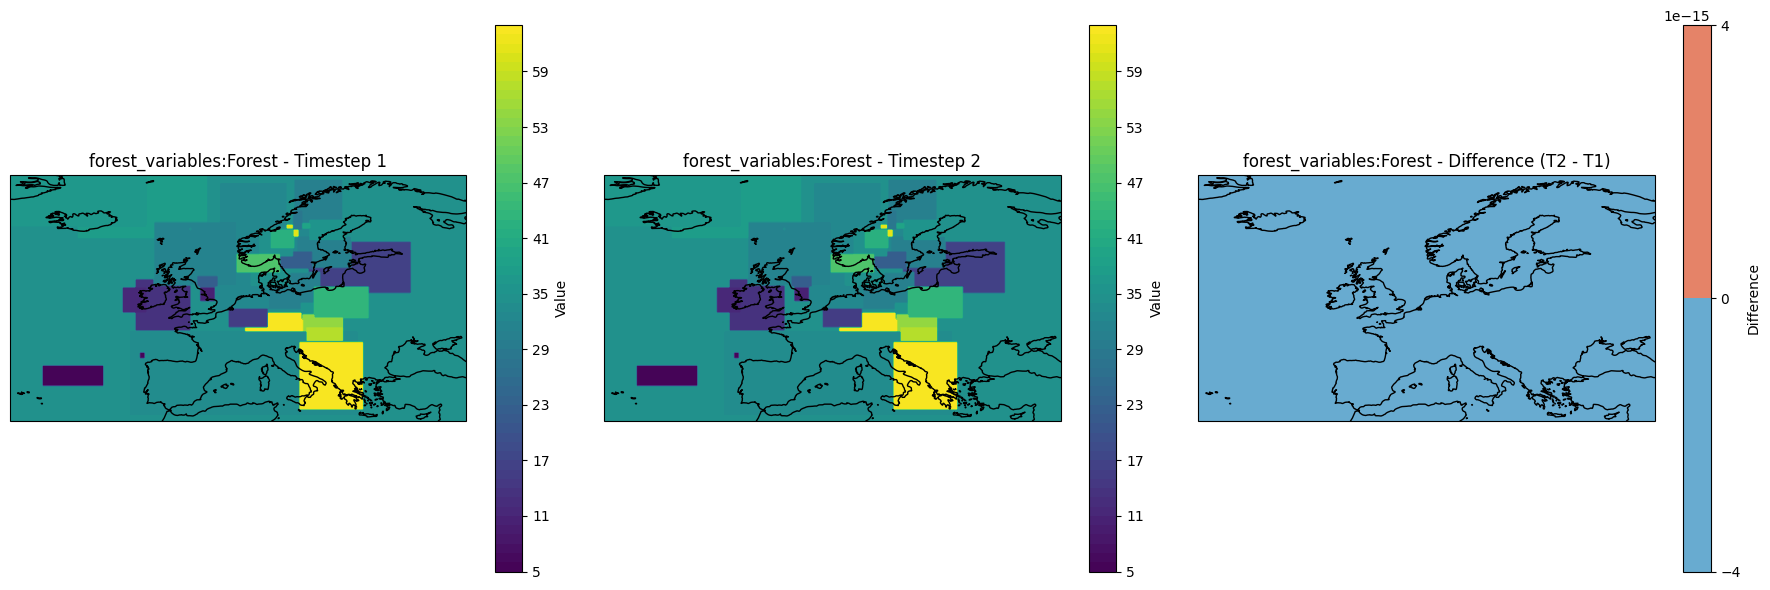

Plotting species_variables:Distribution with shape torch.Size([1, 2, 22, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


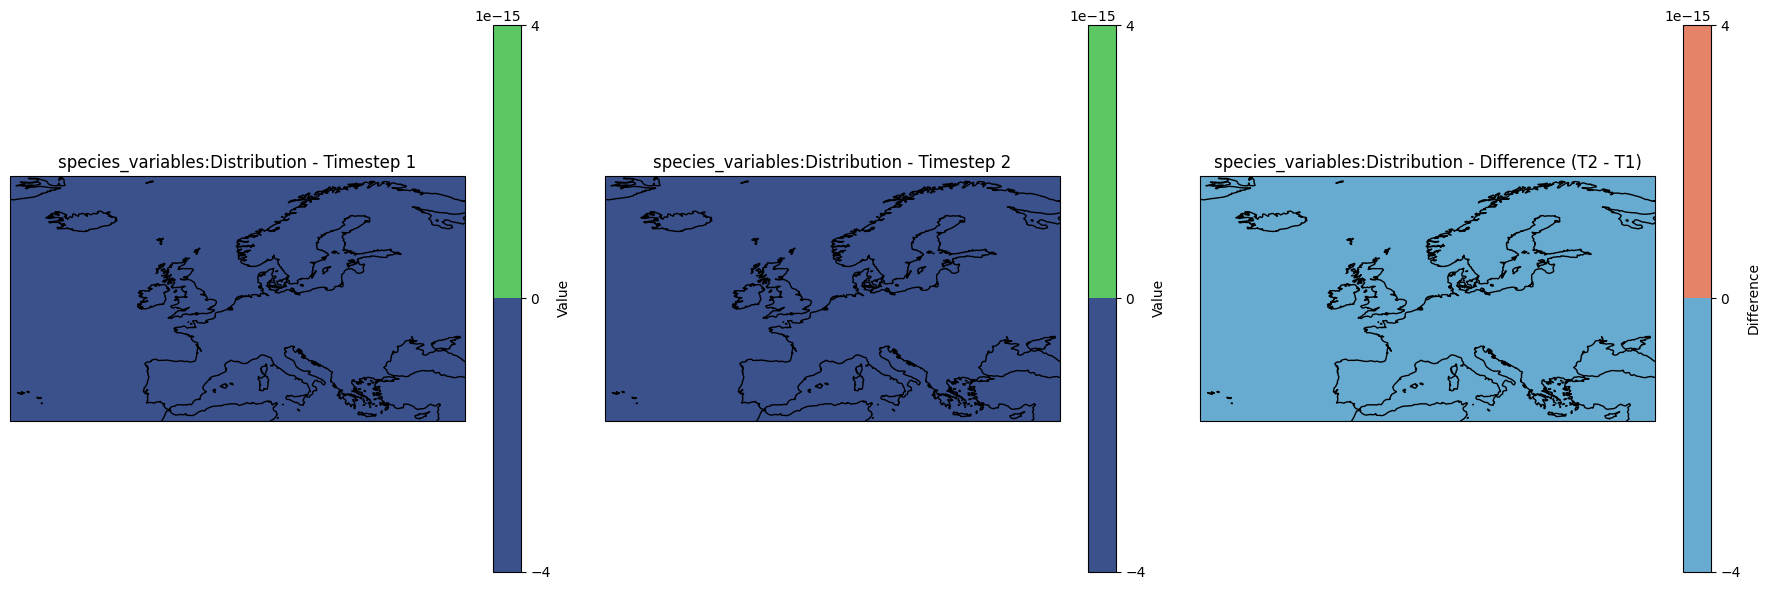

In [6]:
for group_name in groups:
    true_dict = getattr(sample, group_name, {})
    for var_name, tensor in true_dict.items():
        print(f"Plotting {group_name}:{var_name} with shape {tensor.shape}")
        # For 5D tensors with channels, you can choose a channel index.
        if tensor.ndim == 5:
            plot_europe_timesteps_and_difference(f"{group_name}:{var_name}", tensor, channel_idx=0)
        else:
            plot_europe_timesteps_and_difference(f"{group_name}:{var_name}", tensor)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import torch

def plot_europe_timesteps_and_difference(var_name: str,
                                         tensor: torch.Tensor,
                                         timestamps: list,
                                         pressure_levels: list = None,
                                         output_dir: str = "./plots",
                                         channels: list = None):
    """
    Plots and saves maps for Timestep 1, Timestep 2, and their difference over Europe,
    using fixed coordinate arrays. It also includes metadata in the titles and filenames.
    
    Parameters:
      var_name (str): Name of the variable (used for titles and filenames).
      tensor (torch.Tensor): Input tensor with shape:
           - 4D: [batch, 2, lat, lon], or
           - 5D: [batch, 2, channel, lat, lon].
      timestamps (list): List of two timestamp strings, e.g. ['2020-05-29T18:00:00', '2020-05-30T00:00:00'].
      pressure_levels (list, optional): List of pressure levels corresponding to each channel (for atmospheric variables).
      output_dir (str): Directory where plots will be saved.
      channels (list, optional): List of channel indices to plot (if tensor is 5D). If not provided, all channels will be plotted.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert tensor to numpy.
    tensor_np = tensor.cpu().numpy()
    
    # Determine whether we have a channel dimension.
    if tensor_np.ndim == 4:
        # [batch, 2, lat, lon] -> treat as single channel.
        channels_to_plot = [0]
    elif tensor_np.ndim == 5:
        num_channels = tensor_np.shape[2]
        channels_to_plot = channels if channels is not None else list(range(num_channels))
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor_np.shape}")
    
    # Fixed coordinate arrays:
    # Latitude: 152 points from 72.0 down to 34.25, then sorted ascending.
    lat_fixed = np.linspace(72, 34.25, 152)
    lat_fixed = np.sort(lat_fixed)  # Now from 34.25 to 72.0.
    # Longitude: 320 points linearly spaced from -30.0 to 40.0.
    lon_fixed = np.linspace(-30, 40, 320)
    # Create a meshgrid.
    Lon, Lat = np.meshgrid(lon_fixed, lat_fixed, indexing='xy')
    
    # Define Europe bounding box.
    europe_extent = [-30, 40, 34.25, 72]
    
    # Unpack timestamps.
    if len(timestamps) != 2:
        raise ValueError("timestamps must be a list of two elements (for Timestep 1 and Timestep 2).")
    tstamp0, tstamp1 = timestamps
    
    # Loop over channels.
    for ch in channels_to_plot:
        # Extract t1 and t2 from tensor.
        if tensor_np.ndim == 4:
            t1_data = tensor_np[0, 0, :, :]
            t2_data = tensor_np[0, 1, :, :]
        else:
            t1_data = tensor_np[0, 0, ch, :, :]
            t2_data = tensor_np[0, 1, ch, :, :]
        
        diff_data = t2_data - t1_data
        
        # Construct additional metadata for title/filename.
        pressure_info = ""
        if "surface_variables" in var_name and pressure_levels is not None:
            try:
                pressure_info = f"_p{pressure_levels[ch]}"
            except IndexError:
                pressure_info = ""
        
        # Create figure with 3 subplots.
        fig, axes = plt.subplots(1, 3, figsize=(18, 6),
                                 subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Plot Timestep 1.
        ax = axes[0]
        ax.set_extent(europe_extent, crs=ccrs.PlateCarree())
        try:
            ax.coastlines(resolution='50m')
        except Exception as e:
            print("Error drawing coastlines on Timestep 1:", e)
        cf1 = ax.contourf(Lon, Lat, t1_data, levels=60, cmap='viridis',
                          transform=ccrs.PlateCarree())
        ax.set_title(f"{var_name} (Ch {ch}{pressure_info})\nTimestep 1\n{tstamp0}")
        fig.colorbar(cf1, ax=ax, orientation='vertical', label="Value")
        
        # Plot Timestep 2.
        ax = axes[1]
        ax.set_extent(europe_extent, crs=ccrs.PlateCarree())
        try:
            ax.coastlines(resolution='50m')
        except Exception as e:
            print("Error drawing coastlines on Timestep 2:", e)
        cf2 = ax.contourf(Lon, Lat, t2_data, levels=60, cmap='viridis',
                          transform=ccrs.PlateCarree())
        ax.set_title(f"{var_name} (Ch {ch}{pressure_info})\nTimestep 2\n{tstamp1}")
        fig.colorbar(cf2, ax=ax, orientation='vertical', label="Value")
        
        # Plot Difference.
        ax = axes[2]
        ax.set_extent(europe_extent, crs=ccrs.PlateCarree())
        try:
            ax.coastlines(resolution='50m')
        except Exception as e:
            print("Error drawing coastlines on Difference plot:", e)
        cf_diff = ax.contourf(Lon, Lat, diff_data, levels=60, cmap='RdBu_r',
                              transform=ccrs.PlateCarree())
        ax.set_title(f"{var_name} (Ch {ch}{pressure_info})\nDifference (T2-T1)")
        fig.colorbar(cf_diff, ax=ax, orientation='vertical', label="Difference")
        
        plt.tight_layout()
        
        # Construct filename.
        filename = os.path.join(
            output_dir,
            f"{var_name}_ch{ch}{pressure_info}_t0_{tstamp0}_t1_{tstamp1}.png"
        )
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved plot: {filename}")



# Loop over groups and plot each variable using the metadata.
for group_name in groups:
    true_dict = getattr(sample, group_name, {})
    for var_name, tensor in true_dict.items():
        print(f"Plotting {group_name}:{var_name} with shape {tensor.shape}")
        # Extract metadata for timestamps and pressure levels.
        metadata = sample.batch_metadata
        timestamps = metadata.timestamp
        pressure_levels = metadata.pressure_levels
        plot_europe_timesteps_and_difference(f"{group_name}:{var_name}", tensor,
                                             timestamps=timestamps,
                                             pressure_levels=pressure_levels,
                                             output_dir="./plots")


Plotting surface_variables:t2m with shape torch.Size([1, 2, 152, 320])
Saved plot: ./plots/surface_variables:t2m_ch0_p50_t0_2020-05-29T18:00:00_t1_2020-05-30T00:00:00.png
Plotting surface_variables:msl with shape torch.Size([1, 2, 152, 320])
Saved plot: ./plots/surface_variables:msl_ch0_p50_t0_2020-05-29T18:00:00_t1_2020-05-30T00:00:00.png
Plotting single_variables:lsm with shape torch.Size([1, 2, 152, 320])
Saved plot: ./plots/single_variables:lsm_ch0_p50_t0_2020-05-29T18:00:00_t1_2020-05-30T00:00:00.png
Plotting atmospheric_variables:z with shape torch.Size([1, 2, 3, 152, 320])
Saved plot: ./plots/atmospheric_variables:z_ch0_p50_t0_2020-05-29T18:00:00_t1_2020-05-30T00:00:00.png
Saved plot: ./plots/atmospheric_variables:z_ch1_p500_t0_2020-05-29T18:00:00_t1_2020-05-30T00:00:00.png
Saved plot: ./plots/atmospheric_variables:z_ch2_p1000_t0_2020-05-29T18:00:00_t1_2020-05-30T00:00:00.png
Plotting atmospheric_variables:t with shape torch.Size([1, 2, 3, 152, 320])
Saved plot: ./plots/atmosphe